In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors 
from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [6]:
# Import the dataset and give the column names
finefoods_df=pd.read_csv('Reviews2.csv')

In [7]:
#HEad of data to see what the data looks like
finefoods_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
finefoods_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [9]:
#Check the number of rows and columns
rows,columns=finefoods_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  568454
Number of columns:  10


In [10]:
#Check the datatypes
finefoods_df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [11]:
#Taking subset of the dataset
finefoods_df1=finefoods_df.head(50000)

In [12]:
finefoods_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
Id                        50000 non-null int64
ProductId                 50000 non-null object
UserId                    50000 non-null object
ProfileName               49997 non-null object
HelpfulnessNumerator      50000 non-null int64
HelpfulnessDenominator    50000 non-null int64
Score                     50000 non-null int64
Time                      50000 non-null int64
Summary                   49998 non-null object
Text                      50000 non-null object
dtypes: int64(5), object(5)
memory usage: 3.8+ MB


In [13]:
#Summary statistics of rating variable
finefoods_df1['Score'].describe().transpose()

count    50000.000000
mean         4.145840
std          1.325596
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Score, dtype: float64

In [14]:
#Find the minimum and maximum ratings
print('Minimum Rating is: %d' %(finefoods_df1.Score.min()))
print('Maximum Rating is: %d' %(finefoods_df1.Score.max()))

Minimum Rating is: 1
Maximum Rating is: 5


In [15]:
#Check for missing values
print('Number of missing values across columns: \n',finefoods_df.isnull().sum())

Number of missing values across columns: 
 Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [16]:
finefoods_df.drop('Time',axis=1,inplace=True)


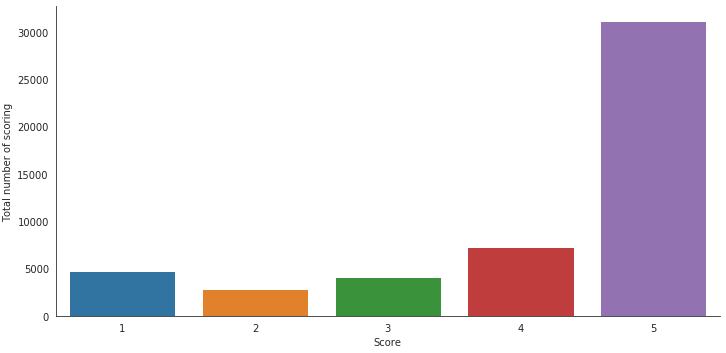

In [17]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Score", data=finefoods_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of scoring")

In [18]:
# Number of unique user id  in the data
print('Number of unique users in Raw data = ', finefoods_df1['UserId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', finefoods_df1['ProductId'].nunique())

Number of unique users in Raw data =  40048
Number of unique product in Raw data =  6115


In [19]:
#Check the top 10 users based on ratings
most_rated=finefoods_df1.groupby('UserId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 UserId
AY12DBB0U420B     44
A3OXHLG6DIBRW8    39
A1YUL9PCJR3JTY    35
A1Z54EM24Y40LL    35
A1TMAVN4CEM8U8    31
A281NPSIMI1C2R    29
A2SZLNSI5KOQJT    22
A3HPCRD9RX351S    21
A3PJZ8TU8FDQ1K    21
A31N6KB160O508    20
dtype: int64


In [20]:
counts=finefoods_df1.UserId.value_counts()
finefoods_df1_final=finefoods_df1[finefoods_df1.UserId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(finefoods_df1_final))
print('Number of unique users in the final data = ', finefoods_df1_final['UserId'].nunique())
print('Number of unique products in the final data = ', finefoods_df1_final['UserId'].nunique())

Number of users who have rated 25 or more items = 377
Number of unique users in the final data =  15
Number of unique products in the final data =  15


In [21]:
#constructing the pivot table
final_ratings_matrix = finefoods_df1_final.pivot(index = 'Id', columns ='ProductId', values = 'Score').fillna(0)
final_ratings_matrix.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (377, 262)


In [23]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  377
possible_num_of_ratings =  98774
density: 0.38%


In [24]:
#Split the data randomnly into train and test datasets into 80:20 ratio
train_data, test_data = train_test_split(finefoods_df1_final, test_size = 0.20, random_state=0)
train_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
24368,24369,B007OADN6C,A1Z54EM24Y40LL,c2,0,0,5,1338076800,Completely awesome!,If you happen to have someone in your house th...
14932,14933,B004YPV15A,AY12DBB0U420B,Gary Peterson,1,2,5,1330387200,A Tasty Treat With Fiber and a Good Shelf Life.,We usually have a case of Orville Redenbacher ...
27520,27521,B001HTG3IQ,AY12DBB0U420B,Gary Peterson,0,0,5,1309219200,The Best!,"I first remember Martinelli""s Apple Juice from..."
7773,7774,B007J6KEPY,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,5,1332633600,Outstanding Flavor - Highly Recommended,"These David's Signature Beyond Gourmet ""Pomegr..."
16441,16442,B007TJGZ54,A1Z54EM24Y40LL,c2,0,0,4,1350345600,"Not the best, but CERTAINLY, not the worst!","This is a breakfast blend coffee and, for many..."


In [25]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (301, 10)
Shape of testing data:  (76, 10)


In [26]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'Score'},inplace=True)
train_data_grouped.head(40)

,ProductId,Score
0,B000084EK4,1
1,B000084EK8,1
2,B000084EKA,1
3,B000084EKB,1
4,B000084EKC,1
5,B000084EKD,1
6,B000084EKG,1
7,B00008JOL0,1
8,B0000A0BS8,1
9,B0000TWLJ4,1


In [27]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['Score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['Score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductId,Score,Rank
192,B0058AMY74,9,1.0
199,B006N3IG4K,7,2.0
160,B003VXFK44,6,3.0
190,B0051TPWUI,6,4.0
50,B000G6RYNE,5,5.0


In [28]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [29]:
find_recom = [5,500,40000]   # This list is our/user's choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n")

The list of recommendations for the userId: 5

     userId   ProductId  Score  Rank
192       5  B0058AMY74      9   1.0
199       5  B006N3IG4K      7   2.0
160       5  B003VXFK44      6   3.0
190       5  B0051TPWUI      6   4.0
50        5  B000G6RYNE      5   5.0


The list of recommendations for the userId: 500

     userId   ProductId  Score  Rank
192     500  B0058AMY74      9   1.0
199     500  B006N3IG4K      7   2.0
160     500  B003VXFK44      6   3.0
190     500  B0051TPWUI      6   4.0
50      500  B000G6RYNE      5   5.0


The list of recommendations for the userId: 40000

     userId   ProductId  Score  Rank
192   40000  B0058AMY74      9   1.0
199   40000  B006N3IG4K      7   2.0
160   40000  B003VXFK44      6   3.0
190   40000  B0051TPWUI      6   4.0
50    40000  B000G6RYNE      5   5.0




In [30]:
#Building Collaborative Filtering recommender model
finefoods_df_CF = pd.concat([train_data, test_data]).reset_index()
finefoods_df_CF.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,24368,24369,B007OADN6C,A1Z54EM24Y40LL,c2,0,0,5,1338076800,Completely awesome!,If you happen to have someone in your house th...
1,14932,14933,B004YPV15A,AY12DBB0U420B,Gary Peterson,1,2,5,1330387200,A Tasty Treat With Fiber and a Good Shelf Life.,We usually have a case of Orville Redenbacher ...
2,27520,27521,B001HTG3IQ,AY12DBB0U420B,Gary Peterson,0,0,5,1309219200,The Best!,"I first remember Martinelli""s Apple Juice from..."
3,7773,7774,B007J6KEPY,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",0,0,5,1332633600,Outstanding Flavor - Highly Recommended,"These David's Signature Beyond Gourmet ""Pomegr..."
4,16441,16442,B007TJGZ54,A1Z54EM24Y40LL,c2,0,0,4,1350345600,"Not the best, but CERTAINLY, not the worst!","This is a breakfast blend coffee and, for many..."


In [31]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = finefoods_df_CF.pivot(index = 'Id', columns ='ProductId', values = 'Score').fillna(0)
pivot_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (377, 262)


In [33]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2,user_index
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [34]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 10)

In [35]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 3.41340746e-17  3.42828417e-16 -2.99875539e-17 ...  3.68996550e-17
   1.35475994e-17 -1.67577702e-21]
 [-8.06101935e-05 -3.17189635e-17  3.34715276e-18 ... -2.71691863e-05
  -4.84746408e-17  2.37089843e-04]
 [-1.61220387e-04  5.31363567e-17 -4.98404373e-18 ... -5.43383726e-05
  -7.78838763e-18  4.74179686e-04]
 ...
 [-4.06043660e-02  4.52969765e-16  3.86218531e-17 ... -1.19855251e-02
  -3.97361020e-15  8.86717358e-02]
 [-4.46547753e-02  4.81856769e-16  5.35593708e-17 ... -1.27668773e-02
  -3.97420153e-15  8.89088901e-02]
 [-2.80642075e-02  3.56685955e-16 -2.23374304e-17 ... -9.74351727e-03
  -4.05452813e-15  8.91457358e-02]]


In [36]:
print('Sigma: \n',sigma)

Sigma: 
 [  11.72584991   12.24744871   12.24744871   12.24744871   12.51430679
   12.52996409   12.80036584   14.51720768   14.62873884 4217.81047516]


In [37]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[  11.72584991    0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.           12.24744871    0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.           12.24744871    0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.           12.24744871    0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.           12.51430679
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
    12.52996409    0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.           12.80036584    0.            0.            0.        ]
 [   0.       

In [38]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-9.56951694e-04 -1.85613430e-03 -1.89050716e-03 ... -2.85294717e-03
  -1.03806029e-02 -7.73358743e-04]
 [ 1.77417069e-16  1.71701056e-17  4.82814091e-16 ...  5.51631034e-17
  -4.77653069e-16  1.11690691e-17]
 [-1.53616622e-17 -1.27415257e-18 -4.58072590e-17 ... -3.83469182e-18
   3.88021928e-17 -6.99369621e-19]
 ...
 [-2.73971772e-04 -5.05309317e-04 -5.14666897e-04 ... -7.76679136e-04
  -2.82598914e-03 -3.47632820e-04]
 [-1.03307076e-17  7.31135485e-18  2.08558034e-16 ... -3.93020592e-17
   3.52116082e-17 -1.57011632e-16]
 [ 8.93763513e-06  1.51771299e-05  1.54581879e-05 ...  2.33278108e-05
   8.48795043e-05  9.99998617e-01]]


In [39]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2,user_index
0,-8.337918e-19,-1.591985e-18,-1.621466e-18,-1.234294e-18,-8.023279e-19,-2.584461e-19,-1.013884e-18,-1.035925e-18,-1.415098e-18,-4.967937e-19,...,-1.058375e-17,-5.896240e-19,-2.146127e-17,-3.484656e-18,-1.319047e-17,-4.187783e-19,-6.839639e-18,-2.446940e-18,-8.903323e-18,-7.848607e-18
1,1.002215e-05,1.726720e-05,1.758697e-05,1.420298e-05,9.643952e-06,3.257832e-06,1.166673e-05,1.192036e-05,1.534863e-05,6.153282e-06,...,1.147949e-04,6.395261e-06,1.932217e-04,3.369084e-05,1.275299e-04,4.818868e-06,7.418503e-05,2.654033e-05,9.656844e-05,9.999996e-01
2,2.004429e-05,3.453441e-05,3.517394e-05,2.840596e-05,1.928790e-05,6.515665e-06,2.333347e-05,2.384071e-05,3.069725e-05,1.230656e-05,...,2.295899e-04,1.279052e-05,3.864433e-04,6.738167e-05,2.550598e-04,9.637736e-06,1.483701e-04,5.308067e-05,1.931369e-04,1.999999e+00
3,3.006644e-05,5.180161e-05,5.276090e-05,4.260894e-05,2.893185e-05,9.773497e-06,3.500020e-05,3.576107e-05,4.604588e-05,1.845985e-05,...,3.443848e-04,1.918578e-05,5.796650e-04,1.010725e-04,3.825898e-04,1.445660e-05,2.225551e-04,7.962100e-05,2.897053e-04,2.999999e+00
4,-3.958635e-05,-7.987689e-05,-8.135610e-05,-6.010894e-05,-3.809253e-05,-1.189158e-05,-4.937520e-05,-5.044857e-05,-7.100168e-05,-2.313549e-05,...,-5.310334e-04,-2.958403e-05,-1.149338e-03,-1.828698e-04,-6.922171e-04,-2.039410e-05,-3.431748e-04,-1.227737e-04,-4.467189e-04,4.000012e+00


In [40]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = UserID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(UserID))
    print(temp.head(num_recommendations))

In [41]:
UserID = 4
num_recommendations = 5
recommend_items(UserID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B004SRH2B6                  0.0          0.001296
B0041NYV8E                  0.0          0.001087
B001E5E268                  0.0          0.000975
B001EQ55RW                  0.0          0.000947
B001EO5QZK                  0.0          0.000902


In [42]:
UserID = 8
num_recommendations = 5
recommend_items(UserID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B001M0XKGI                  0.0          0.000040
B002UP2TG6                  0.0          0.000039
B00317ERXA                  0.0          0.000038
B000OK7XAQ                  0.0          0.000034
B002NHYQAS                  0.0          0.000033


In [43]:
# Actual ratings given by the users
final_ratings_matrix.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0083QJU72,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2
Id,,,,,,,,,,,,,,,,,,,,,
110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

ProductId
B000084EK4    0.007958
B000084EK5    0.013263
B000084EK6    0.013263
B000084EK7    0.010610
B000084EK8    0.007958
dtype: float64

In [45]:
# Predicted ratings 
preds_df.head()

ProductId,B000084EK4,B000084EK5,B000084EK6,B000084EK7,B000084EK8,B000084EK9,B000084EKA,B000084EKB,B000084EKC,B000084EKD,...,B0088OIA66,B0089SPDUW,B008FHUDW0,B008OV8RE8,B008OV91VQ,B008YAXFWI,B0092X7NGU,B0092X7OGY,B0096EZHM2,user_index
0,-8.337918e-19,-1.591985e-18,-1.621466e-18,-1.234294e-18,-8.023279e-19,-2.584461e-19,-1.013884e-18,-1.035925e-18,-1.415098e-18,-4.967937e-19,...,-1.058375e-17,-5.896240e-19,-2.146127e-17,-3.484656e-18,-1.319047e-17,-4.187783e-19,-6.839639e-18,-2.446940e-18,-8.903323e-18,-7.848607e-18
1,1.002215e-05,1.726720e-05,1.758697e-05,1.420298e-05,9.643952e-06,3.257832e-06,1.166673e-05,1.192036e-05,1.534863e-05,6.153282e-06,...,1.147949e-04,6.395261e-06,1.932217e-04,3.369084e-05,1.275299e-04,4.818868e-06,7.418503e-05,2.654033e-05,9.656844e-05,9.999996e-01
2,2.004429e-05,3.453441e-05,3.517394e-05,2.840596e-05,1.928790e-05,6.515665e-06,2.333347e-05,2.384071e-05,3.069725e-05,1.230656e-05,...,2.295899e-04,1.279052e-05,3.864433e-04,6.738167e-05,2.550598e-04,9.637736e-06,1.483701e-04,5.308067e-05,1.931369e-04,1.999999e+00
3,3.006644e-05,5.180161e-05,5.276090e-05,4.260894e-05,2.893185e-05,9.773497e-06,3.500020e-05,3.576107e-05,4.604588e-05,1.845985e-05,...,3.443848e-04,1.918578e-05,5.796650e-04,1.010725e-04,3.825898e-04,1.445660e-05,2.225551e-04,7.962100e-05,2.897053e-04,2.999999e+00
4,-3.958635e-05,-7.987689e-05,-8.135610e-05,-6.010894e-05,-3.809253e-05,-1.189158e-05,-4.937520e-05,-5.044857e-05,-7.100168e-05,-2.313549e-05,...,-5.310334e-04,-2.958403e-05,-1.149338e-03,-1.828698e-04,-6.922171e-04,-2.039410e-05,-3.431748e-04,-1.227737e-04,-4.467189e-04,4.000012e+00


In [46]:
# Average PREDICTED rating for each item
preds_df.mean().head()

ProductId
B000084EK4    0.001660
B000084EK5    0.002815
B000084EK6    0.002867
B000084EK7    0.002337
B000084EK8    0.001597
dtype: float64

In [47]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(263, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
B000084EK4,0.007958,0.001660,0
B000084EK5,0.013263,0.002815,1
B000084EK6,0.013263,0.002867,2
B000084EK7,0.010610,0.002337,3
B000084EK8,0.007958,0.001597,4


In [48]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00722 



In [53]:
# Enter 'userID' and 'num_recommendations' for the user #
UserID = 100
num_recommendations = 10
recommend_items(UserID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 100):

                   user_ratings  user_predictions
Recommended Items                                
B000EUIZ8K                  0.0          0.001321
B000GFYRJ4                  0.0          0.001300
B001O2H9Y8                  0.0          0.001290
B001M0XKGI                  0.0          0.001275
B002UP2TG6                  0.0          0.001238
B004P7T7YY                  0.0          0.001237
B003V7XNRQ                  0.0          0.001226
B00317ERXA                  0.0          0.001224
B000GAUKP4                  0.0          0.001223
B0032GHKXO                  0.0          0.001181
